# Regression demo

This notebook contains two example data sets for which we compute the leverage and DFBETA of each data point.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

# Anscombes quartet

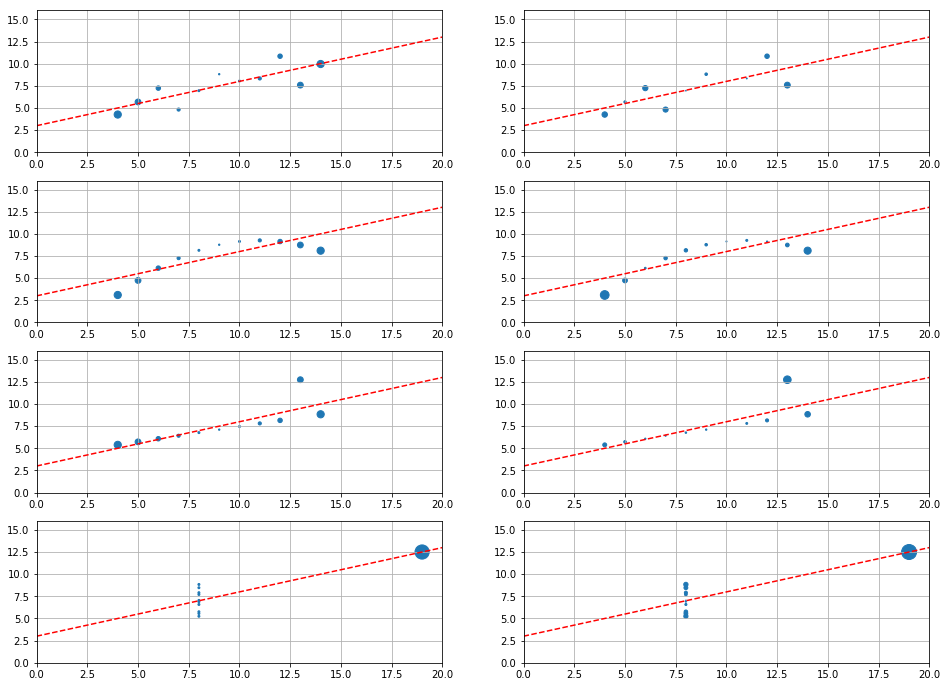

In [2]:
df = pd.read_csv("../data/anscombes_quartet.csv")
plt.figure(figsize=(16,12))

cur = 0
for i in range(1, 5):
    cur += 1
    plt.subplot(4, 2, cur)
    X = df['x{}'.format(i)].values.reshape(-1, 1)
    y = df['y{}'.format(i)]
    model = LinearRegression().fit(X, y)
    # leverages are diag of projection matrix (H)
    # h = np.diag(X@np.linalg.inv(X.T@X)@X.T)

    # leverages
    h = np.array([1/X.shape[0] + (X[i] - X.mean())**2/X.var() for i in range(X.shape[0])])

    # model parameters with all points
    b = np.concatenate((np.array([model.intercept_]), model.coef_))
    # dfbeta summaries, one for each instance, measures the effect of deleting an instance on the model parameters
    dfbeta = []
    for row in range(X.shape[0]):
        Xi = np.concatenate((X[0:row, :], X[row+1:, :]))
        yi = np.concatenate((y[0:row], y[row+1:]))
        modeli = LinearRegression().fit(Xi, yi)
        bi = np.concatenate((np.array([modeli.intercept_]), modeli.coef_))
        dfbetai = b - bi
        dfbeta.append(np.abs(dfbetai).mean())
    dfbeta = np.array(dfbeta)
    df.loc[:, 'x{}_h'.format(i)] = h
    df.loc[:, 'x{}_dfbeta'.format(i)] = dfbeta

    # size coded leverages
    plt.scatter(df['x{}'.format(i)], df['y{}'.format(i)], s=h*20)
    plt.grid(True)
    plt.xlim([0, 20]); plt.ylim([0, 16]);
    plt.plot([0, 20], [model.intercept_, model.intercept_ + 20*model.coef_[0]], 'r--')

    cur += 1
    plt.subplot(4, 2, cur)
    # size coded dfbetas
    plt.scatter(df['x{}'.format(i)], df['y{}'.format(i)], s=dfbeta*100)
    plt.grid(True)
    plt.xlim([0, 20]); plt.ylim([0, 16]);
    plt.plot([0, 20], [model.intercept_, model.intercept_ + 20*model.coef_[0]], 'r--')

# Bike sharing dataset

In [3]:
df = pd.read_csv("../data/bike/day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


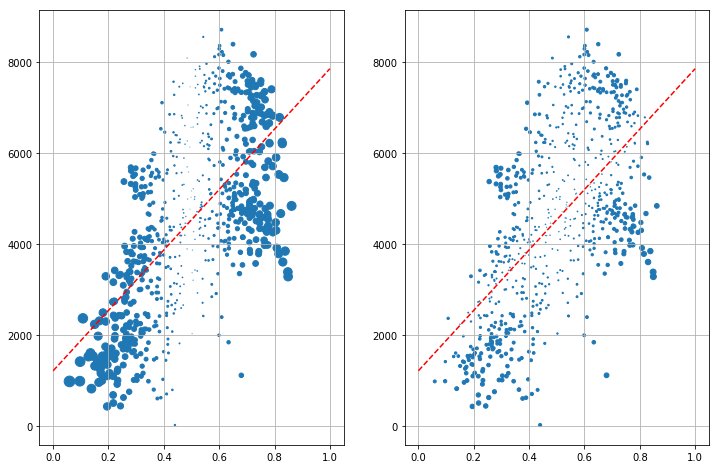

In [4]:
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)

col = 'temp'
#df.loc[0, 'atemp'] = 1
X = df[col].values.reshape(-1, 1)
y = df['cnt']
model = LinearRegression().fit(X, y)
# leverages are diag of projection matrix (H)
# h = np.diag(X@np.linalg.inv(X.T@X)@X.T)

# leverages
h = np.array([1/X.shape[0] + (X[i] - X.mean())**2/X.var() for i in range(X.shape[0])])
# model parameters with all points
b = np.concatenate((np.array([model.intercept_]), model.coef_))
# dfbeta summaries, one for each instance, measures the effect of deleting an instance on the model parameters
dfbeta = []
for row in range(X.shape[0]):
    Xi = np.concatenate((X[0:row, :], X[row+1:, :]))
    yi = np.concatenate((y[0:row], y[row+1:]))
    modeli = LinearRegression().fit(Xi, yi)
    bi = np.concatenate((np.array([modeli.intercept_]), modeli.coef_))
    dfbetai = b - bi
    dfbeta.append(np.abs(dfbetai).mean())
dfbeta = np.array(dfbeta)

# size coded leverages
plt.scatter(X.reshape(-1), y, s=h*20)
plt.grid(True)
plt.plot([0, 1], [model.intercept_, model.intercept_ + 1*model.coef_[0]], 'r--')

plt.subplot(1, 2, 2)

# size coded dfbetas
plt.scatter(X.reshape(-1), y, s=dfbeta)
plt.grid(True)
plt.plot([0, 1], [model.intercept_, model.intercept_ + 1*model.coef_[0]], 'r--')

df.loc[:, '{}_dfbeta'.format(col)] = dfbeta

In [5]:
# count distinct
{col: df[col].nunique() for col in df.columns}

{'instant': 731,
 'dteday': 731,
 'season': 4,
 'yr': 2,
 'mnth': 12,
 'holiday': 2,
 'weekday': 7,
 'workingday': 2,
 'weathersit': 3,
 'temp': 499,
 'atemp': 690,
 'hum': 595,
 'windspeed': 650,
 'casual': 606,
 'registered': 679,
 'cnt': 696,
 'temp_dfbeta': 731}

In [6]:
# completeness
{col: 1-df[col].isna().mean() for col in df.columns}

{'instant': 1.0,
 'dteday': 1.0,
 'season': 1.0,
 'yr': 1.0,
 'mnth': 1.0,
 'holiday': 1.0,
 'weekday': 1.0,
 'workingday': 1.0,
 'weathersit': 1.0,
 'temp': 1.0,
 'atemp': 1.0,
 'hum': 1.0,
 'windspeed': 1.0,
 'casual': 1.0,
 'registered': 1.0,
 'cnt': 1.0,
 'temp_dfbeta': 1.0}

In [7]:
def _numeric_transformer(X):
    return pd.DataFrame([X]).T

col_encoders = {
#     'temp': Pipeline(
#                 # StandardScaler needs a 2d np.array
#                 [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
#     ),
    'temp': Pipeline(
                # StandardScaler needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
    ),
    'workingday': Pipeline(
                # OneHotEncoder needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
    ),
#     'holiday': Pipeline(
#                 # OneHotEncoder needs a 2d np.array
#                 [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
#     ),
    'weathersit': Pipeline(
                # OneHotEncoder needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
                 #('scaler', StandardScaler())]
    ),
    'season': Pipeline(
                # OneHotEncoder needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True)),
                 ('scaler', OneHotEncoder(categories='auto'))]
    ),
}

columns = col_encoders.keys()

transformers = ColumnTransformer([(col, col_encoders[col], col) for col in columns])

# estimator = SGDRegressor('squared_loss', max_iter=1000, tol=1e-6)
estimator = LinearRegression()

model = Pipeline([('transformers', transformers), ('estimator', estimator)])
model

Pipeline(memory=None,
     steps=[('transformers', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('temp', Pipeline(memory=None,
     steps=[('wrapper', FunctionTransformer(accept_sparse=True, check_inverse=True,
          func=<function _numeri...timator', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [8]:
# OneHotEncoder(categories='auto', sparse=False).fit_transform(df.head()[['weekday']])

In [9]:
model.fit(df[columns], df['cnt'])
model.named_steps['estimator'].coef_

array([5798.17884905,  183.5947583 , -887.83052898, -742.2209447 ,
        203.89708187, -175.69488947,  714.0187523 ])

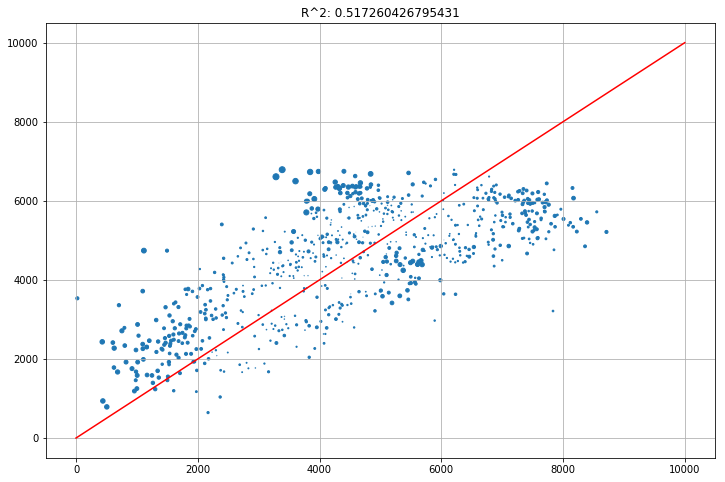

In [10]:
m = 1e4
plt.figure(figsize=(12,8))
plt.scatter(df['cnt'], model.predict(df), s=df['{}_dfbeta'.format(col)])
plt.title('R^2: ' + str(model.score(df[columns], df['cnt'])))
plt.plot([0, m], [0, m], c='red')
plt.grid(True)

In [11]:
# res = df['cnt'] - model.predict(df)
# sns.distplot(res)

In [12]:
# from scipy import stats
# # https://en.wikipedia.org/wiki/Normal_probability_plot
# stats.probplot(res, plot=plt);
# plt.grid(True)

In [13]:
# # effect plot
# # predictions
# # y = (model.named_steps['transformers'].transform(df) * model.named_steps['estimator'].coef_.reshape(-1, 1) + model.named_steps['estimator'].intercept_).squeeze()


# X = model.named_steps['transformers'].transform(df)
# dfs = []
# for i in range(X.shape[1]):
#     e = np.multiply(X[:, i], model.named_steps['estimator'].coef_[i]) + model.named_steps['estimator'].intercept_
#     effect = pd.DataFrame({'e': e.squeeze()})
#     effect.loc[:, 'dim'] = i
#     dfs.append(effect)

# effects = pd.concat(dfs)
# effects.head()
# sns.boxplot(x='dim', y='e', data=effects)

In [14]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html
# sm.OLS(df['cnt'], X).fit().summary()

---

# Decision trees

In [15]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

def _numeric_transformer(X):
    return pd.DataFrame([X]).T

col_encoders = {
#     'temp': Pipeline(
#                 # StandardScaler needs a 2d np.array
#                 [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
#     ),
    'temp': Pipeline(
                # StandardScaler needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
    ),
    'workingday': Pipeline(
                # OneHotEncoder needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
    ),
#     'holiday': Pipeline(
#                 # OneHotEncoder needs a 2d np.array
#                 [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
#     ),
    'weathersit': Pipeline(
                # OneHotEncoder needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
                 #('scaler', StandardScaler())]
    ),
    'season': Pipeline(
                # OneHotEncoder needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True)),
                 ('scaler', OneHotEncoder(categories='auto'))]
    ),
}

columns = col_encoders.keys()

transformers = ColumnTransformer([(col, col_encoders[col], col) for col in columns])

estimator = DecisionTreeRegressor(max_depth=2)

model = Pipeline([('transformers', transformers), ('estimator', estimator)])
model

Pipeline(memory=None,
     steps=[('transformers', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('temp', Pipeline(memory=None,
     steps=[('wrapper', FunctionTransformer(accept_sparse=True, check_inverse=True,
          func=<function _numeri...lit=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'))])

In [16]:
model.fit(df[columns], df['cnt'])

Pipeline(memory=None,
     steps=[('transformers', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('temp', Pipeline(memory=None,
     steps=[('wrapper', FunctionTransformer(accept_sparse=True, check_inverse=True,
          func=<function _numeri...lit=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'))])

In [19]:
export_graphviz(model.named_steps['estimator'], 'regression_tree.dot', proportion=True, rotate=True)
# sudo apt install graphviz
! dot -Tpng regression_tree.dot -o regression_tree.png
! ls

classification.ipynb	 decision_tree.dot  regression_tree.dot
classification_tree.dot  decision_tree.png  regression_tree.png
classification_tree.png  regression.ipynb


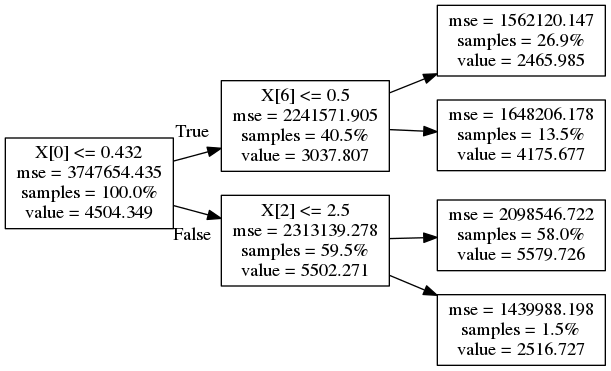

In [20]:
from IPython.display import Image
Image(filename='regression_tree.png')

In [21]:
model.named_steps['estimator'].feature_importances_

array([0.784896  , 0.        , 0.07380175, 0.        , 0.        ,
       0.        , 0.14130225])